In [1]:
# 랭그래프를 활용한 Agent 구축
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# TAVILY 웹검색 도구(Tool)
# https://app.tavily.com/
# TAVILY_API_KEY

In [3]:
from langchain_teddynote.tools.tavily import TavilySearch

# 검색 도구 생성
tool = TavilySearch(max_results=3)

# 도구 목록에 추가
tools = [tool]

# 도구 실행
print(tool.invoke("테디노트 랭체인 튜토리얼"))

[{'url': 'https://www.youtube.com/watch?v=mVu6Wj8Z7C0', 'title': '#랭체인 한국어 튜토리얼🇰🇷 업데이트 소식🔥 처음 사용자를 ...', 'content': '#랭체인 한국어 튜토리얼🇰🇷 업데이트 소식🔥 처음 사용자를 위한 친절한 환경설치(Windows, Mac)\n테디노트 TeddyNote\n46600 subscribers\n329 likes\n18193 views\n19 Jun 2024\n📝 환경설정(Windows)\nhttps://teddynote.com/10-RAG%EB%B9%84%EB%B2%95%EB%85%B8%ED%8A%B8/%ED%99%98%EA%B2%BD%20%EC%84%A4%EC%A0%95%20(Windows)/\n\n📝 환경설정(Mac)\nhttps://teddynote.com/10-RAG%EB%B9%84%EB%B2%95%EB%85%B8%ED%8A%B8/%ED%99%98%EA%B2%BD%20%EC%84%A4%EC%A0%95%20(Mac)/\n\n📍[패스트캠퍼스] "테디노트의 RAG 비법노트" 강의\n링크: https://bit.ly/4e1h8zO\n\n🤖 디스코드 채널\nhttps://discord.gg/q3RvQZ5CfK\n\n📘 랭체인 튜토리얼 무료 전자책(wikidocs)\nhttps://wikidocs.net/book/14314\n\n✅ 랭체인 한국어 튜토리얼 코드저장소(GitHub)\nhttps://github.com/teddylee777/langchain-kr\n\n✅ 줄거리\n00:00 랭체인 한국어 튜토리얼 공지사항\n01:59 langchain-teddynote 패키지\n08:25 감사인사\n09:15 Windows 환경설치\n21:48 Mac 환경설치\n\n#rag #langchain\n---\n📍 "테디노트의 RAG 비법노트" 랭체인 강의: https://fastcampus.co.kr/data_online_teddy\n📘 랭체인 한국어 튜토리얼(무료 전자책): https:/

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

# 1. State 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [5]:
from langchain_openai import ChatOpenAI
# 2. Node 정의

llm = ChatOpenAI(model='gpt-5-nano')

# llm 에 도구
llm_with_tools = llm.bind_tools(tools)

# 노드 생성
def chatbot(state : State):
    answer = llm_with_tools.invoke(state["messages"])
    return {"messages": [answer]}

In [6]:
# 3. StateGraph 생성 + 노드 추가
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

In [7]:
# 노드 생성
# 도구 노드
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 호출 결과
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}


# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)


In [8]:
### Conditinoal Edge
### 조건부 엣지
from langgraph.graph import START, END

def route_tools(state : State):
    if messages := state.get("messages", []):
        # 가장 최근 메시지
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    # AI에 도구 호출이 있으면 tools 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    # 도구호출 없으면 END
    return END

In [9]:
graph_builder.add_edge(START, "chatbot")            # START -> chatbot

graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,               # 반환값이 tools면 tools 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools":"tools", END: END}
)

graph_builder.add_edge("tools", "chatbot")          # tools -> chatbot


# 컴파일
graph = graph_builder.compile()


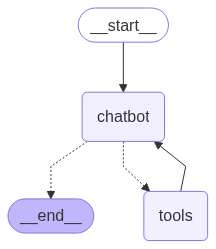

In [ ]:
# 그래프 시각화
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
from langchain_teddynote.messages import display_message_tree

question = "테디노트 Youtube"

for event in graph.stream({"messages": [("user", question)]}):
    for key, value in event.items():
        print(f"\n============\nSTEP: {key}\n=============\n")
        display_message_tree(value["messages"][-1])


STEP: chatbot

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                id: "call_O1FlITwMpzYy7qkGYjT7uB8E"
                function: {"arguments": "{"query":"테디노트 YouTube"}", "name": "tavily_web_search"}
                type: "function"
        refusal: None
    response_metadata:
        token_usage:
            completion_tokens: 543
            prompt_tokens: 177
            total_tokens: 720
            completion_tokens_details: {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 512, "rejected_prediction_tokens": 0}
            prompt_tokens_details: {"audio_tokens": 0, "cached_tokens": 0}
        model_name: "gpt-5-nano-2025-08-07"
        system_fingerprint: None
        id: "chatcmpl-CBY0oDv31iRMuksX8XGuc0OXeiImt"
        service_tier: "default"
        finish_reason: "tool_calls"
        logprobs: None
    type: "ai"
    name: None
    id: "run--895803a2-a4a9-4541-b2c3-55f56f8b9691-0"
    example: False
    tool_c

In [12]:
# 메모리 기억능력 추가
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()          # 메모리 저장소

In [13]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

### 1. 상태 정의
class MyState(TypedDict):
    messages: Annotated[list, add_messages]

### 2. 도구 정의
tool = TavilySearch(max_results=3)
tools = [tool]

llm = ChatOpenAI(model="gpt-5-nano")
llm_with_tools = llm.bind_tools(tools)

# 노드 정의
def chatbot(state: MyState):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# 상태 그래프 생성 및 노드 추가
graph_builder = StateGraph(MyState)
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# 조건부 엣지 / 엣지로 노드끼리 연결
graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.add_edge("tools", "chatbot")          # tools -> chatbot
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [14]:
# 메모리를 제공해서 컴파일
graph = graph_builder.compile(checkpointer=memory)

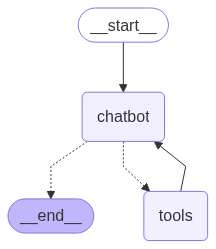

In [ ]:
# 시각화
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# 최대 순환 수
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "1"})            # 쓰레드 ID 설정 (같은 쓰레드ID에 대해서 대화내용이 기억됨)

In [17]:
question = "내 이름은 `성종` 입니다. 만나서 반가워요"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================

성종님, 만나서 반가워요! 무엇을 도와드릴까요? 오늘은 어떤 주제로 이야기해 볼까요? 필요하신 게 있으면 말씀해 주세요.


In [18]:
question = "내 이름이 뭐라고 했지?"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================

당신의 이름은 성종이라고 하셨습니다.


In [21]:
# 스냅샷 : State 확인
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(configurable={"thread_id": "1"})

snapshot = graph.get_state(config)
snapshot.values["messages"]

[HumanMessage(content='내 이름은 `성종` 입니다. 만나서 반가워요', additional_kwargs={}, response_metadata={}, id='6f9e9e36-83f5-49c0-bb10-11c2a8fb88e8'),
 AIMessage(content='성종님, 만나서 반가워요! 무엇을 도와드릴까요? 오늘은 어떤 주제로 이야기해 볼까요? 필요하신 게 있으면 말씀해 주세요.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 560, 'prompt_tokens': 187, 'total_tokens': 747, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 512, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CBYDyBOqXDETYXhqL7q6OPyQkEv0y', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f1db5918-2b2e-4d66-b4ee-ab9481a7b639-0', usage_metadata={'input_tokens': 187, 'output_tokens': 560, 'total_tokens': 747, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 512

In [22]:
snapshot.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f088741-92ec-6ce2-8004-b110e115f396'}}

In [24]:
snapshot.values

{'messages': [HumanMessage(content='내 이름은 `성종` 입니다. 만나서 반가워요', additional_kwargs={}, response_metadata={}, id='6f9e9e36-83f5-49c0-bb10-11c2a8fb88e8'),
  AIMessage(content='성종님, 만나서 반가워요! 무엇을 도와드릴까요? 오늘은 어떤 주제로 이야기해 볼까요? 필요하신 게 있으면 말씀해 주세요.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 560, 'prompt_tokens': 187, 'total_tokens': 747, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 512, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CBYDyBOqXDETYXhqL7q6OPyQkEv0y', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f1db5918-2b2e-4d66-b4ee-ab9481a7b639-0', usage_metadata={'input_tokens': 187, 'output_tokens': 560, 'total_tokens': 747, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'r